## Loading the dataset

In [1]:
import pandas as pd
df = pd.read_csv("../year_week.csv")
df.head()

,production,p_per_m2,p_max,panel_area,facade_area,total_panel_area,exploitation_ratio,air_temp_mean,air_temp_max,clearsky_ghi_mean,...,relative_humidity_max,surface_pressure_mean,surface_pressure_min,surface_pressure_max,wind_direction_100m_mean,wind_direction_100m_min,wind_direction_100m_max,wind_speed_100m_mean,wind_speed_100m_min,wind_speed_100m_max
0,5.200000,143.0,210.0,1.72,218.0,94.6,0.434,2.505230,4.200000,60.951418,...,94.220000,1034.960009,1033.440000,1037.220000,270.313918,194.000000,328.400000,4.257234,1.920000,5.860000
1,1.400000,143.0,210.0,1.72,218.0,94.6,0.434,2.479167,4.000000,60.812500,...,95.900000,1034.843750,1031.700000,1038.100000,259.770833,227.000000,339.000000,5.036170,2.000000,6.200000
2,2.742857,143.0,210.0,1.72,218.0,94.6,0.434,2.639881,3.571429,64.693452,...,92.528571,1025.654167,1022.557143,1028.500000,246.068452,156.428571,311.714286,5.367262,3.328571,7.528571
3,1.200000,143.0,210.0,1.72,218.0,94.6,0.434,2.895833,4.000000,64.312500,...,93.500000,1024.008333,1020.000000,1027.300000,251.979167,213.000000,300.000000,4.456250,2.500000,7.700000
4,14.614286,143.0,210.0,1.72,218.0,94.6,0.434,3.446429,5.857143,71.940476,...,91.314286,1015.603869,1011.585714,1020.142857,210.104167,169.714286,266.285714,5.892857,3.800000,7.757143


In [2]:
df.shape

(3174, 34)

## Preoaring the (x,y) pairs

### Scaling the data

In [3]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values)

### Creating windows

In [4]:
production_column = 'production'

def get_target_column_index(df, target_column):
    for i, column in enumerate(df.columns):
        if column == target_column:
            return i

    return -1

In [5]:
import numpy as np

def get_windows(data, window_size=10):
    x = []
    y = []

    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i])
        y.append(data[i][get_target_column_index(df, production_column)])

    return np.array(x), np.array(y)

In [6]:
window_size = 2*12  # 2*1h window
x, y = get_windows(data_scaled, window_size=window_size)

x.shape, y.shape

((3150, 24, 34), (3150,))

### Splitting the data

In [7]:
train_split_index = int(0.8 * len(df))
test_split_index = int(0.9 * len(df))

x_train, y_train = x[:train_split_index], y[:train_split_index]
x_test, y_test = x[train_split_index:test_split_index], y[train_split_index:test_split_index]
x_val, y_val = x[test_split_index:], y[test_split_index:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((2539, 24, 34), (2539,), (317, 24, 34), (317,), (294, 24, 34), (294,))

### Plotting the splits

In [8]:
import matplotlib.pyplot as plt


def plot_time_series(timesteps, values, label, format='-^', start=0, end=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("date")
    plt.ylabel("production")

    plt.legend(fontsize=14)
    plt.grid(True)

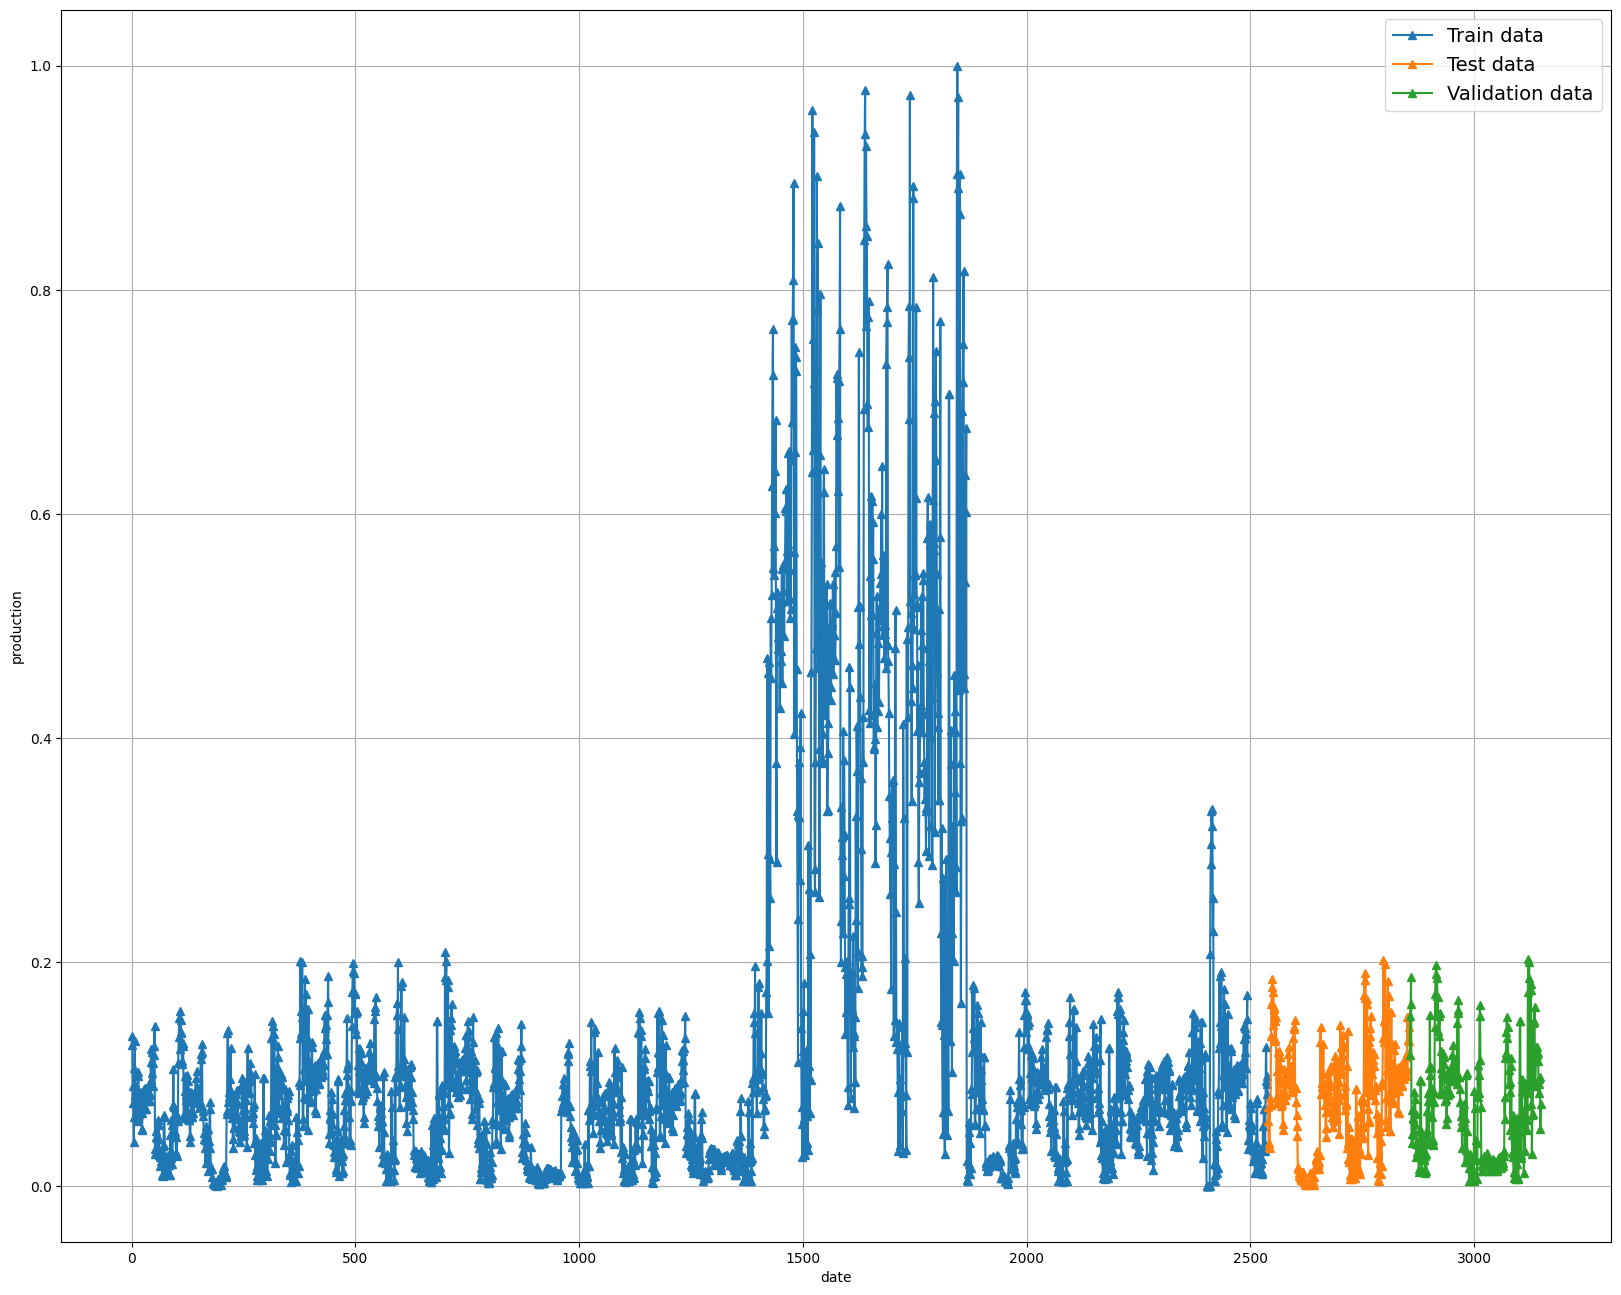

In [9]:
plt.figure(figsize=(20, 16))

timesteps = range(len(x_train))
plot_time_series(timesteps=timesteps, values=y_train, label="Train data")

timesteps = range(len(x_train), len(x_train) + len(x_test))
plot_time_series(timesteps=timesteps, values=y_test, label="Test data")

timesteps = range(len(x_train) + len(x_test),
                  len(x_train) + len(x_test) + len(x_val))
plot_time_series(timesteps=timesteps, values=y_val, label="Validation data")

### Preparing the performances metrics

In [10]:
import tensorflow as tf
from sklearn.metrics import r2_score

In [11]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'mape': mape,
    }

In [12]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mse_metric = tf.keras.metrics.MeanSquaredError()

    mae_metric.update_state(y_true, y_pred)
    mse_metric.update_state(y_true, y_pred)

    mae = mae_metric.result().numpy()
    mse = mse_metric.result().numpy()
    r2 = r2_score(y_true.numpy(), y_pred.numpy())  # Assure-toi que y_true et y_pred sont des numpy arrays

    return {
        "mae": mae,
        "mse": mse,
        "r2": r2
    }

## Modeling

In [13]:
import os
import tensorflow as tf

from keras.layers import Dense, Dropout, LSTM, Flatten, ConvLSTM1D, MaxPool1D, GlobalMaxPool1D, Conv1D, Conv2D
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

### Plotting the loss

In [14]:
def plot_loss(history):
    plt.figure(figsize=(20, 8))

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Creating callbacks

In [15]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)


def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0,
                                              save_best_only=True)

### Utils function

In [16]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

## ConvLSTM

#### Preparing the model

In [17]:
x_train_conv_lstm = np.expand_dims(x_train, axis=2)
x_val_conv_lstm = np.expand_dims(x_val, axis=2)
x_test_conv_lstm = np.expand_dims(x_test, axis=2)

print(f"{x_train.shape} -> {x_train_conv_lstm.shape}")

(2539, 24, 34) -> (2539, 24, 1, 34)


In [18]:
tf.random.set_seed(42)

input_shape = (x_train_conv_lstm.shape[1:])
conv_lstm_model = tf.keras.Sequential([
    ConvLSTM1D(filters=64, kernel_size=(1,), activation='tanh',
               return_sequences=True, input_shape=input_shape),
    ConvLSTM1D(filters=64, kernel_size=(1,),
               activation='tanh', return_sequences=False),
    Flatten(),
    Dense(units=64, activation='relu'),
    Dense(1, activation="linear")
], name="model_conv_lstm.keras")

conv_lstm_model.compile(loss="mae",
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

conv_lstm_model.summary()

C:\Users\yhoci\blocml\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "model_conv_lstm.keras"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm1d (ConvLSTM1D)             │ (None, 24, 1, 64)           │          25,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm1d_1 (ConvLSTM1D)           │ (None, 1, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,593 (244.50 KB)

 Trainable params: 62,593 (244.50 KB)

 Non-trainable params: 0 (0.00 B)

#### Training the model convlstm

In [19]:
import os
import time
import logging
from codecarbon import EmissionsTracker


os.makedirs('emissions', exist_ok=True)

tracker_conv_lstm = EmissionsTracker(
    project_name="PEWH",
    co2_signal_api_token="9RkoBO6iipmoq",
    log_level=logging.INFO,
    output_file="emissions_conv_lstm.csv",
    output_dir='./emissions/',
    save_to_file=True,
    measure_power_secs=10
)

[codecarbon INFO @ 22:58:31] [setup] RAM Tracking...
[codecarbon INFO @ 22:58:31] [setup] CPU Tracking...
[codecarbon WARNING @ 22:58:31] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 22:58:33] We saw that you have a AMD Ryzen 7 7840HS w/ Radeon 780M Graphics but we don't know it. Please contact us.
[codecarbon INFO @ 22:58:33] CPU Model on constant consumption mode: AMD Ryzen 7 7840HS w/ Radeon 780M Graphics
[codecarbon INFO @ 22:58:33] [setup] GPU Tracking...
[codecarbon INFO @ 22:58:33] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 22:58:33] >>> Tracker's metadata:
[codecarbon INFO @ 22:58:33]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 22:58:33]   Python version: 3.12.3
[codecarbon INFO @ 22:58:33]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 22:58:33]   Available RAM : 15.288 GB
[codecarbon INFO @ 22:58:33]   CPU count: 16
[codecarbon INFO @ 22:

In [20]:
def start_training_conv_lstm():
    start_time = time.time()
    conv_lstm_history = conv_lstm_model.fit(x=x_train_conv_lstm,
                                            y=y_train,
                                            epochs=300,
                                            verbose=1,
                                            batch_size=512,
                                            validation_data=(
                                                x_val_conv_lstm, y_val),
                                            callbacks=[create_model_checkpoint(model_name=conv_lstm_model.name)])
    training_duration = time.time() - start_time

    return conv_lstm_history, training_duration

In [21]:
tracker_conv_lstm.start()
try:
    history_conv_lstm, training_duration_conv_lstm = start_training_conv_lstm()
finally:
    tracker_conv_lstm.stop()

Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 248ms/step - loss: 0.1448 - val_loss: 0.0575
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0881 - val_loss: 0.0419
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0700 - val_loss: 0.0425
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0588 - val_loss: 0.0380
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0550 - val_loss: 0.0379
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0541 - val_loss: 0.0363
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0514 - val_loss: 0.0378
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0505 - val_loss: 0.0375
Epoch 9/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0498 - val_loss: 0.0351
Epoch 10/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0487

[codecarbon INFO @ 22:58:43] Energy consumed for RAM : 0.000016 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 22:58:43] Energy consumed for all CPUs : 0.000118 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:58:43] Energy consumed for all GPUs : 0.000021 kWh. Total GPU Power : 7.627156775152555 W
[codecarbon INFO @ 22:58:43] 0.000156 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0486 - val_loss: 0.0354
Epoch 11/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0480 - val_loss: 0.0363
Epoch 12/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0475 - val_loss: 0.0358
Epoch 13/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0469 - val_loss: 0.0346
Epoch 14/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0466 - val_loss: 0.0351
Epoch 15/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0459 - val_loss: 0.0353
Epoch 16/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0457 - val_loss: 0.0351
Epoch 17/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0453 - val_loss: 0.0361
Epoch 18/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0449 - val_loss: 0.0352
Epoch 19/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0445 - val_loss: 0.0343
Epoch 20/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0441 - val_loss: 0.0340
Epoch 21/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0438 - val_loss: 

[codecarbon INFO @ 22:58:53] Energy consumed for RAM : 0.000032 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 22:58:53] Energy consumed for all CPUs : 0.000237 kWh. Total CPU Power : 42.5 W


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0399

[codecarbon INFO @ 22:58:53] Energy consumed for all GPUs : 0.000031 kWh. Total GPU Power : 3.4483718451741905 W
[codecarbon INFO @ 22:58:53] 0.000299 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0409 - val_loss: 0.0317
Epoch 35/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0408 - val_loss: 0.0309
Epoch 36/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0396 - val_loss: 0.0304
Epoch 37/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0394 - val_loss: 0.0319
Epoch 38/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0392 - val_loss: 0.0306
Epoch 39/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0387 - val_loss: 0.0306
Epoch 40/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0390 - val_loss: 0.0303
Epoch 41/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0384 - val_loss: 0.0329
Epoch 42/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0399 - val_loss: 0.0317
Epoch 43/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0392 - val_loss: 0.0289
Epoch 44/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0384 - val_loss: 0.0301
Epoch 45/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0395 - val_loss: 

[codecarbon INFO @ 22:59:03] Energy consumed for RAM : 0.000048 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 22:59:03] Energy consumed for all CPUs : 0.000355 kWh. Total CPU Power : 42.5 W


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0369

[codecarbon INFO @ 22:59:03] Energy consumed for all GPUs : 0.000045 kWh. Total GPU Power : 5.272137148822216 W
[codecarbon INFO @ 22:59:03] 0.000448 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0369 - val_loss: 0.0261
Epoch 58/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0362 - val_loss: 0.0273
Epoch 59/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0362 - val_loss: 0.0259
Epoch 60/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0357 - val_loss: 0.0263
Epoch 61/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0362 - val_loss: 0.0261
Epoch 62/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0350 - val_loss: 0.0256
Epoch 63/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0348 - val_loss: 0.0244
Epoch 64/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0349 - val_loss: 0.0260
Epoch 65/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0353 - val_loss: 0.0310
Epoch 66/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0372 - val_loss: 0.0254
Epoch 67/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0344 - val_loss: 0.0247
Epoch 68/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0344 - val_loss: 

[codecarbon INFO @ 22:59:13] Energy consumed for RAM : 0.000064 kWh. RAM Power : 5.732982158660889 W


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0325

[codecarbon INFO @ 22:59:13] Energy consumed for all CPUs : 0.000473 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:59:13] Energy consumed for all GPUs : 0.000061 kWh. Total GPU Power : 5.6579515715056 W
[codecarbon INFO @ 22:59:13] 0.000598 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0326 - val_loss: 0.0253
Epoch 82/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0327 - val_loss: 0.0236
Epoch 83/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0323 - val_loss: 0.0236
Epoch 84/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0333 - val_loss: 0.0248
Epoch 85/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0337 - val_loss: 0.0262
Epoch 86/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0338 - val_loss: 0.0234
Epoch 87/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0326 - val_loss: 0.0245
Epoch 88/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0334 - val_loss: 0.0249
Epoch 89/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0335 - val_loss: 0.0237
Epoch 90/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0317 - val_loss: 0.0227
Epoch 91/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0312 - val_loss: 0.0231
Epoch 92/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0315 - val_loss: 

[codecarbon INFO @ 22:59:23] Energy consumed for RAM : 0.000080 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 22:59:23] Energy consumed for all CPUs : 0.000591 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:59:23] Energy consumed for all GPUs : 0.000076 kWh. Total GPU Power : 5.434795215598576 W
[codecarbon INFO @ 22:59:23] 0.000747 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0302 - val_loss: 0.0234
Epoch 107/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0305 - val_loss: 0.0242
Epoch 108/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0313 - val_loss: 0.0222
Epoch 109/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0305 - val_loss: 0.0225
Epoch 110/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0313 - val_loss: 0.0229
Epoch 111/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0336 - val_loss: 0.0237
Epoch 112/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0335 - val_loss: 0.0235
Epoch 113/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0309 - val_loss: 0.0218
Epoch 114/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0300 - val_loss: 0.0239
Epoch 115/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0308 - val_loss: 0.0228
Epoch 116/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0303 - val_loss: 0.0210
Epoch 117/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0307 -

[codecarbon INFO @ 22:59:33] Energy consumed for RAM : 0.000095 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 22:59:33] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W


2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0279

[codecarbon INFO @ 22:59:33] Energy consumed for all GPUs : 0.000085 kWh. Total GPU Power : 3.237169434365932 W
[codecarbon INFO @ 22:59:33] 0.000890 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0287 - val_loss: 0.0209
Epoch 131/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0289 - val_loss: 0.0219
Epoch 132/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0289 - val_loss: 0.0218
Epoch 133/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0286 - val_loss: 0.0205
Epoch 134/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0293 - val_loss: 0.0212
Epoch 135/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0292 - val_loss: 0.0210
Epoch 136/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0292 - val_loss: 0.0210
Epoch 137/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0282 - val_loss: 0.0213
Epoch 138/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0278 - val_loss: 0.0205
Epoch 139/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0278 - val_loss: 0.0200
Epoch 140/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0278 - val_loss: 0.0213
Epoch 141/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0289 -

[codecarbon INFO @ 22:59:43] Energy consumed for RAM : 0.000111 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 22:59:43] Energy consumed for all CPUs : 0.000827 kWh. Total CPU Power : 42.5 W


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0262

[codecarbon INFO @ 22:59:43] Energy consumed for all GPUs : 0.000103 kWh. Total GPU Power : 6.318050950596243 W
[codecarbon INFO @ 22:59:43] 0.001041 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0267 - val_loss: 0.0204
Epoch 156/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0269 - val_loss: 0.0202
Epoch 157/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0265 - val_loss: 0.0201
Epoch 158/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0261 - val_loss: 0.0202
Epoch 159/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0267 - val_loss: 0.0199
Epoch 160/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0264 - val_loss: 0.0205
Epoch 161/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0272 - val_loss: 0.0209
Epoch 162/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0278 - val_loss: 0.0197
Epoch 163/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0259 - val_loss: 0.0198
Epoch 164/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0270 - val_loss: 0.0198
Epoch 165/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0268 - val_loss: 0.0194
Epoch 166/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0261 -

[codecarbon INFO @ 22:59:53] Energy consumed for RAM : 0.000127 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 22:59:53] Energy consumed for all CPUs : 0.000946 kWh. Total CPU Power : 42.5 W


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0257

[codecarbon INFO @ 22:59:53] Energy consumed for all GPUs : 0.000126 kWh. Total GPU Power : 8.390178865598111 W
[codecarbon INFO @ 22:59:53] 0.001199 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0259 - val_loss: 0.0204
Epoch 180/300
2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0245

[codecarbon INFO @ 22:59:53] 0.000224 g.CO2eq/s mean an estimation of 7.078312060285728 kg.CO2eq/year


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0254 - val_loss: 0.0231
Epoch 181/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0267 - val_loss: 0.0189
Epoch 182/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0252 - val_loss: 0.0208
Epoch 183/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0259 - val_loss: 0.0194
Epoch 184/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0257 - val_loss: 0.0191
Epoch 185/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0252 - val_loss: 0.0200
Epoch 186/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0248 - val_loss: 0.0195
Epoch 187/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0251 - val_loss: 0.0188
Epoch 188/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0253 - val_loss: 0.0181
Epoch 189/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0251 - val_loss: 0.0201
Epoch 190/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0246 - val_loss: 0.0190
Epoch 191/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0258 -

[codecarbon INFO @ 23:00:03] Energy consumed for RAM : 0.000143 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 23:00:03] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:00:03] Energy consumed for all GPUs : 0.000139 kWh. Total GPU Power : 4.75394384347989 W
[codecarbon INFO @ 23:00:03] 0.001346 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0254 - val_loss: 0.0183
Epoch 204/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0259 - val_loss: 0.0191
Epoch 205/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0251 - val_loss: 0.0205
Epoch 206/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0253 - val_loss: 0.0197
Epoch 207/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0255 - val_loss: 0.0202
Epoch 208/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0250 - val_loss: 0.0195
Epoch 209/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0242 - val_loss: 0.0199
Epoch 210/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0237 - val_loss: 0.0190
Epoch 211/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0238 - val_loss: 0.0183
Epoch 212/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0236 - val_loss: 0.0181
Epoch 213/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0237 - val_loss: 0.0187
Epoch 214/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0235 

[codecarbon INFO @ 23:00:13] Energy consumed for RAM : 0.000159 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 23:00:13] Energy consumed for all CPUs : 0.001182 kWh. Total CPU Power : 42.5 W


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0211

[codecarbon INFO @ 23:00:13] Energy consumed for all GPUs : 0.000162 kWh. Total GPU Power : 8.194511338729217 W
[codecarbon INFO @ 23:00:13] 0.001503 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0227 - val_loss: 0.0194
Epoch 229/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0234 - val_loss: 0.0193
Epoch 230/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0235 - val_loss: 0.0182
Epoch 231/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0239 - val_loss: 0.0188
Epoch 232/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0246 - val_loss: 0.0196
Epoch 233/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0235 - val_loss: 0.0198
Epoch 234/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0237 - val_loss: 0.0186
Epoch 235/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0244 - val_loss: 0.0186
Epoch 236/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0242 - val_loss: 0.0188
Epoch 237/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0230 - val_loss: 0.0187
Epoch 238/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0236 - val_loss: 0.0182
Epoch 239/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0228 -

[codecarbon INFO @ 23:00:23] Energy consumed for RAM : 0.000175 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 23:00:23] Energy consumed for all CPUs : 0.001300 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:00:23] Energy consumed for all GPUs : 0.000177 kWh. Total GPU Power : 5.279710819642495 W
[codecarbon INFO @ 23:00:23] 0.001651 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0220 - val_loss: 0.0177
Epoch 253/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0226 - val_loss: 0.0182
Epoch 254/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0234 - val_loss: 0.0193
Epoch 255/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0224 - val_loss: 0.0183
Epoch 256/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0221 - val_loss: 0.0177
Epoch 257/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0225 - val_loss: 0.0181
Epoch 258/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0231 - val_loss: 0.0186
Epoch 259/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0233 - val_loss: 0.0181
Epoch 260/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0220 - val_loss: 0.0201
Epoch 261/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0231 - val_loss: 0.0174
Epoch 262/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0219 - val_loss: 0.0185
Epoch 263/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0229 -

[codecarbon INFO @ 23:00:33] Energy consumed for RAM : 0.000191 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 23:00:33] Energy consumed for all CPUs : 0.001418 kWh. Total CPU Power : 42.5 W


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0209

[codecarbon INFO @ 23:00:33] Energy consumed for all GPUs : 0.000191 kWh. Total GPU Power : 5.2013237792394 W
[codecarbon INFO @ 23:00:33] 0.001800 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0211 - val_loss: 0.0174
Epoch 278/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0207 - val_loss: 0.0175
Epoch 279/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0209 - val_loss: 0.0170
Epoch 280/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0215 - val_loss: 0.0182
Epoch 281/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0216 - val_loss: 0.0179
Epoch 282/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0211 - val_loss: 0.0189
Epoch 283/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0219 - val_loss: 0.0199
Epoch 284/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0223 - val_loss: 0.0176
Epoch 285/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0217 - val_loss: 0.0181
Epoch 286/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0235 - val_loss: 0.0186
Epoch 287/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0223 - val_loss: 0.0198
Epoch 288/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0231 -

[codecarbon INFO @ 23:00:43] Energy consumed for RAM : 0.000206 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 23:00:43] Energy consumed for all CPUs : 0.001531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:00:43] Energy consumed for all GPUs : 0.000210 kWh. Total GPU Power : 6.990560464304044 W
[codecarbon INFO @ 23:00:43] 0.001946 kWh of electricity used since the beginning.


#### Ploting the loss

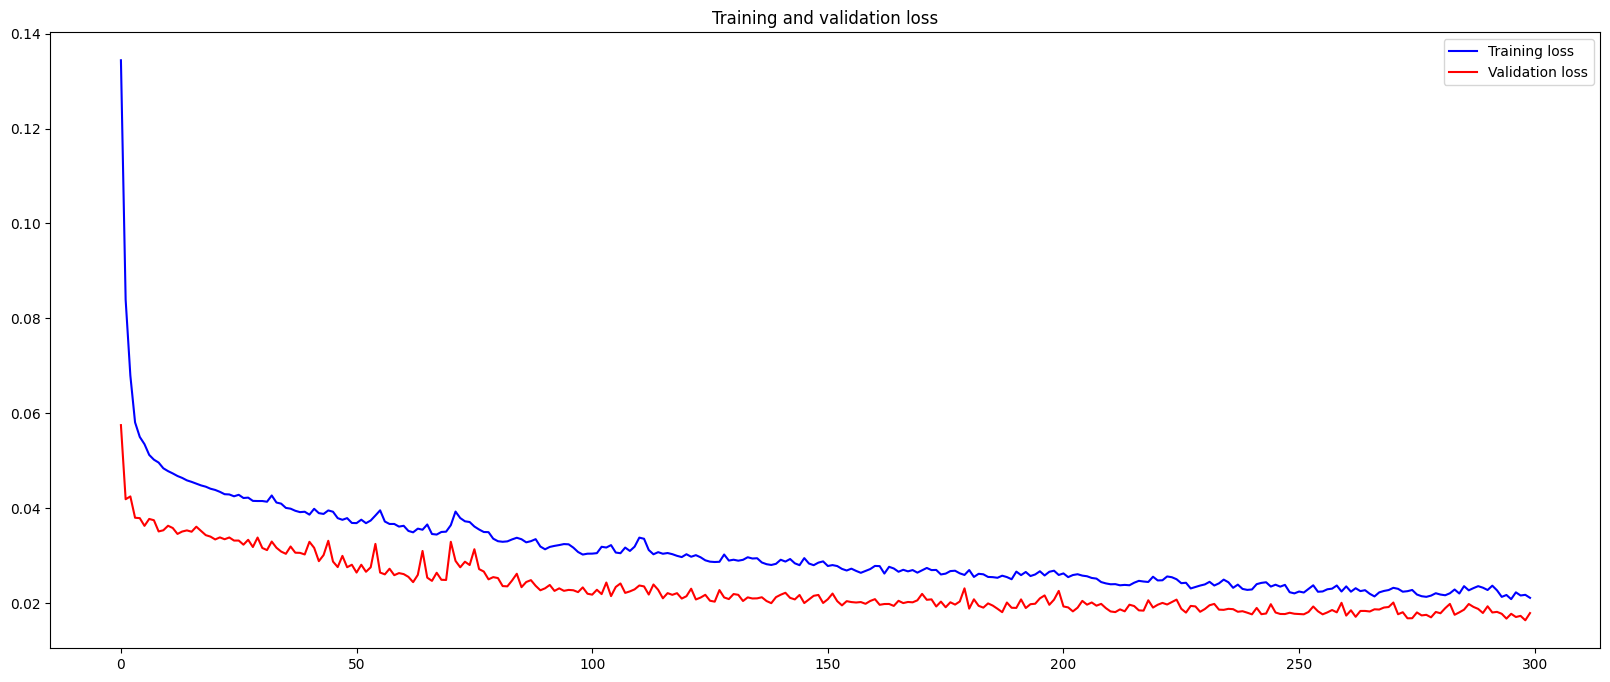

In [22]:
plot_loss(history_conv_lstm)

In [23]:
conv_lstm_model = tf.keras.models.load_model(
    "model_experiments/model_conv_lstm.keras")

model_preds = make_preds(conv_lstm_model, x_test_conv_lstm)
model_results = evaluate_preds(y_true=tf.squeeze(y_test),
                               y_pred=model_preds)

model_results

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step 


{'mae': np.float32(0.013078019),
 'mse': np.float32(0.00034475038),
 'r2': 0.8495186567306519}

#### Plot predictions

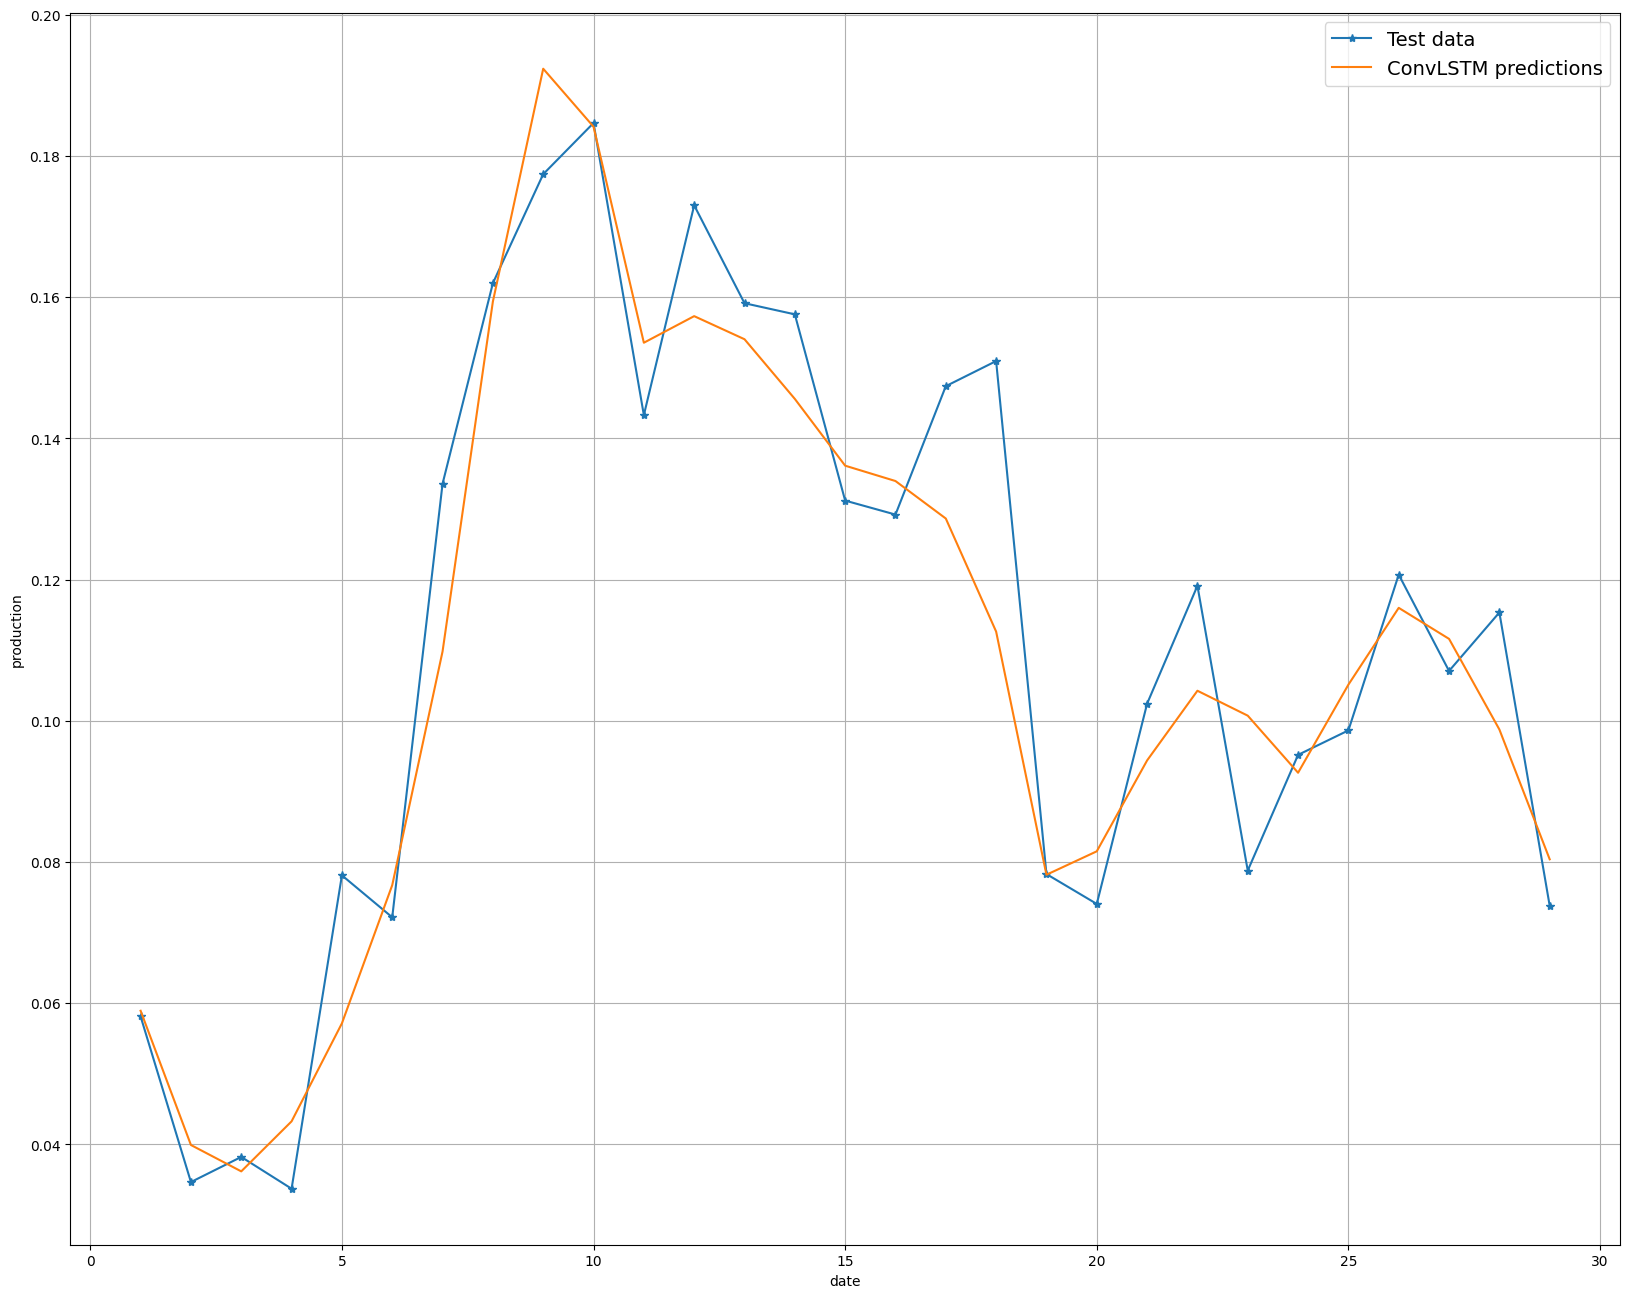

In [24]:
import numpy as np

start_offset = 1
end_offset = 30
plt.figure(figsize=(20, 16))


plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=y_test,
    start=start_offset,
    end=end_offset,
    format='-*',
    label="Test data"
)

plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=model_preds,
    start=start_offset,
    end=end_offset,
    format="-",
    label="ConvLSTM predictions"
)

In [25]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Définition de la fonction objective pour Optuna
def objective(trial):
    # Suggestions d'hyperparamètres
    filters1 = trial.suggest_categorical('filters1', [16, 32, 64, 96, 128])
    filters2 = trial.suggest_categorical('filters2', [16, 32, 64, 96, 128])
    kernel_size = trial.suggest_categorical('kernel_size', [1])  # Fixé à 1
    activation1 = trial.suggest_categorical('activation1', ['relu', 'tanh'])
    activation2 = trial.suggest_categorical('activation2', ['relu', 'tanh'])
    dense_units = trial.suggest_categorical('dense_units', [32, 64, 96, 128])
    learning_rate = trial.suggest_loguniform('learning_rate', 0.0001, 0.008)
    
    # Construction du modèle avec ces hyperparamètres
    model = Sequential([
        ConvLSTM1D(filters=filters1, kernel_size=(kernel_size,), activation=activation1,
                   return_sequences=True, input_shape=x_train_conv_lstm.shape[1:]),
        ConvLSTM1D(filters=filters2, kernel_size=(kernel_size,), activation=activation2, return_sequences=False),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dense(1, activation="linear")
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mae')
    
    # Entraînement rapide pour l'optimisation
    model.fit(x_train_conv_lstm, y_train, epochs=10, batch_size=32, verbose=0, validation_data=(x_val_conv_lstm, y_val))
    score = model.evaluate(x_val_conv_lstm, y_val, verbose=0)
    return score

# Lancer l'étude Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Affichage des meilleurs hyperparamètres trouvés
print("Best hyperparameters:", study.best_params)


[I 2025-04-02 23:00:45,095] A new study created in memory with name: no-name-d01533cc-2f92-467c-ad51-84fbbb525c3d
C:\Users\yhoci\AppData\Local\Temp\ipykernel_39576\1573941806.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.0001, 0.008)
C:\Users\yhoci\blocml\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-04-02 23:01:09,410] Trial 0 finished with value: 0.03247915208339691 and parameters: {'filters1': 128, 'filters2': 16, 'kernel_size': 1, 'activation1': 'tanh', 'activation2': 'relu', 'dense_units': 32, 'learning_rate': 0.0007295103305996394}. B

Best hyperparameters: {'filters1': 96, 'filters2': 64, 'kernel_size': 1, 'activation1': 'tanh', 'activation2': 'tanh', 'dense_units': 32, 'learning_rate': 0.0016163507080940505}
